# ECG Filtro de linea en Python

En este notebook vamos a ver distintas formas de filtrado de la linea

Populating the interactive namespace from numpy and matplotlib
Mounted at /content/drive


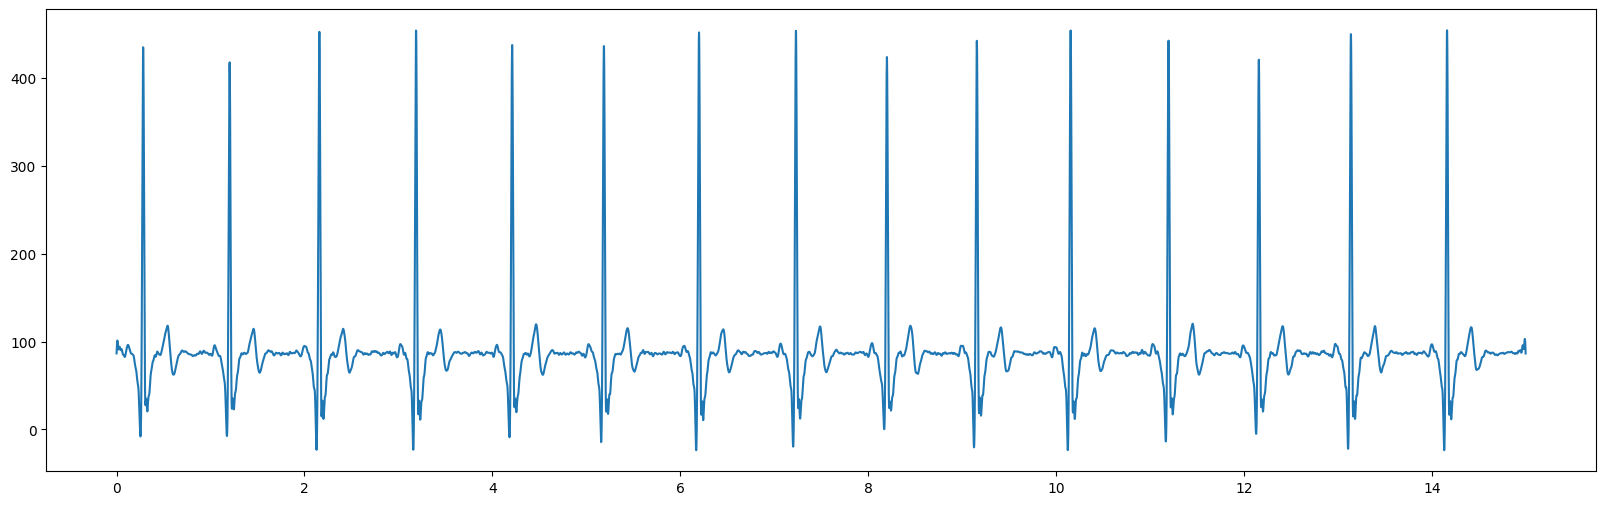

In [1]:
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
import scipy.signal as sig
from scipy.fftpack import fft, ifft, fftshift, rfft, irfft, fftfreq
import math
from google.colab import drive
drive.mount('/content/drive')
my_path = '/content/drive/MyDrive/PES/python-notebooks/6-extras/'


pylab.rcParams['figure.figsize'] = (20, 6)

s = np.loadtxt(my_path+'ecg_filtered.txt')

Fs= 1000
N = len(s)
t = np.arange(0, (1.0*N)/Fs, 1.0/Fs)
plt.plot(t, s)

## agregando un ruido

Se agrega un ruido de linea puro, una senoidal en 50Hz

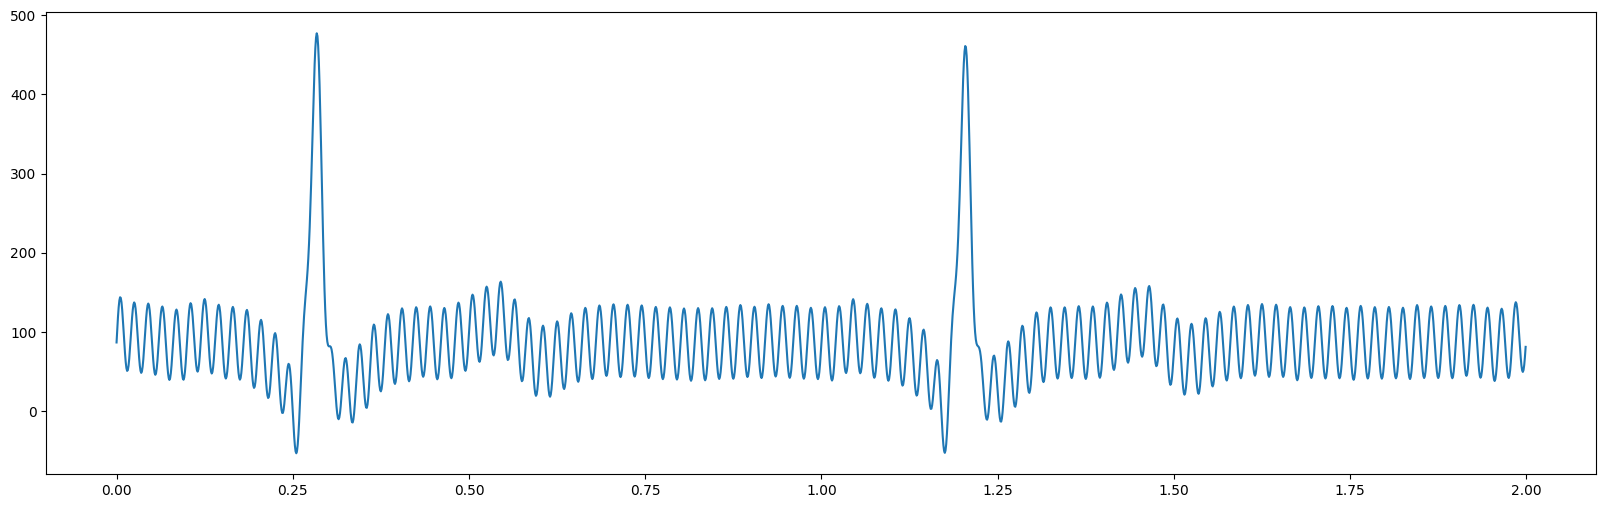

In [2]:
noise_level = np.max(s) * 10/100
n = noise_level * np.sin(2*np.pi*50*t)
sn = s + n
plt.plot(t[0:2*Fs], sn[0:Fs*2])

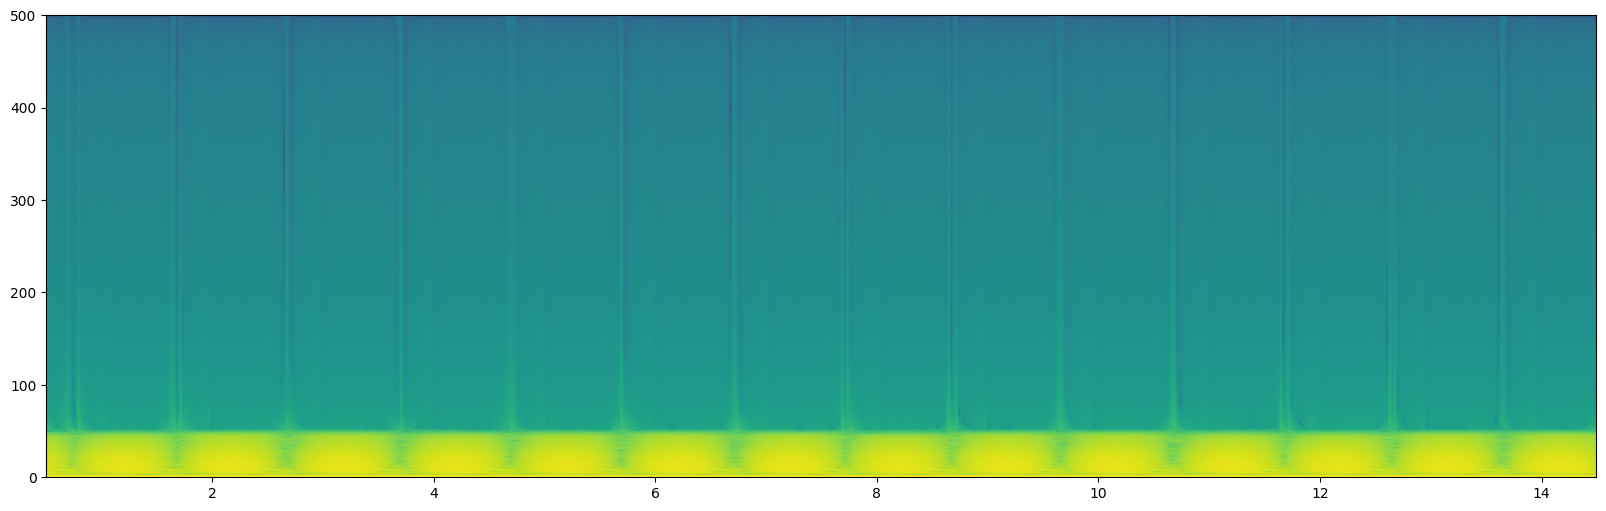

In [3]:
Pxx, freqs, bins, im = plt.specgram((s), NFFT=1024, Fs=Fs, noverlap=1000)
plt.show()

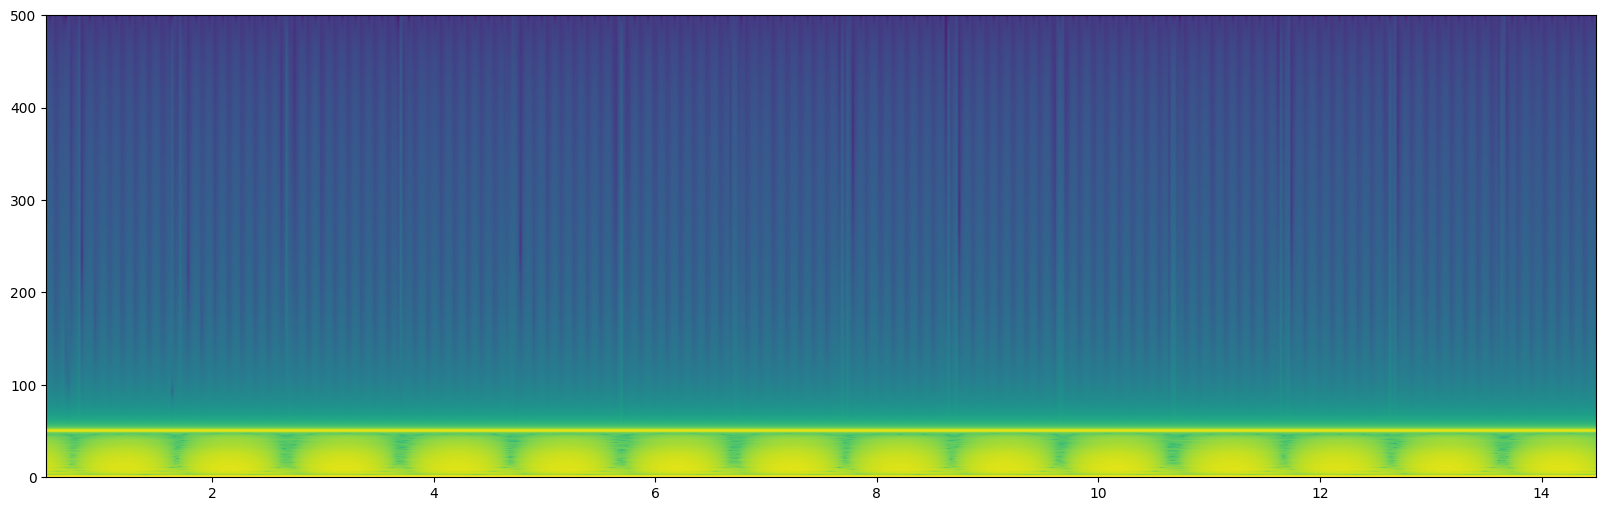

In [4]:
Pxx, freqs, bins, im = plt.specgram((sn), NFFT=1024, Fs=Fs, noverlap=1000)
plt.show()

SNR: 9.822388873083632 dB


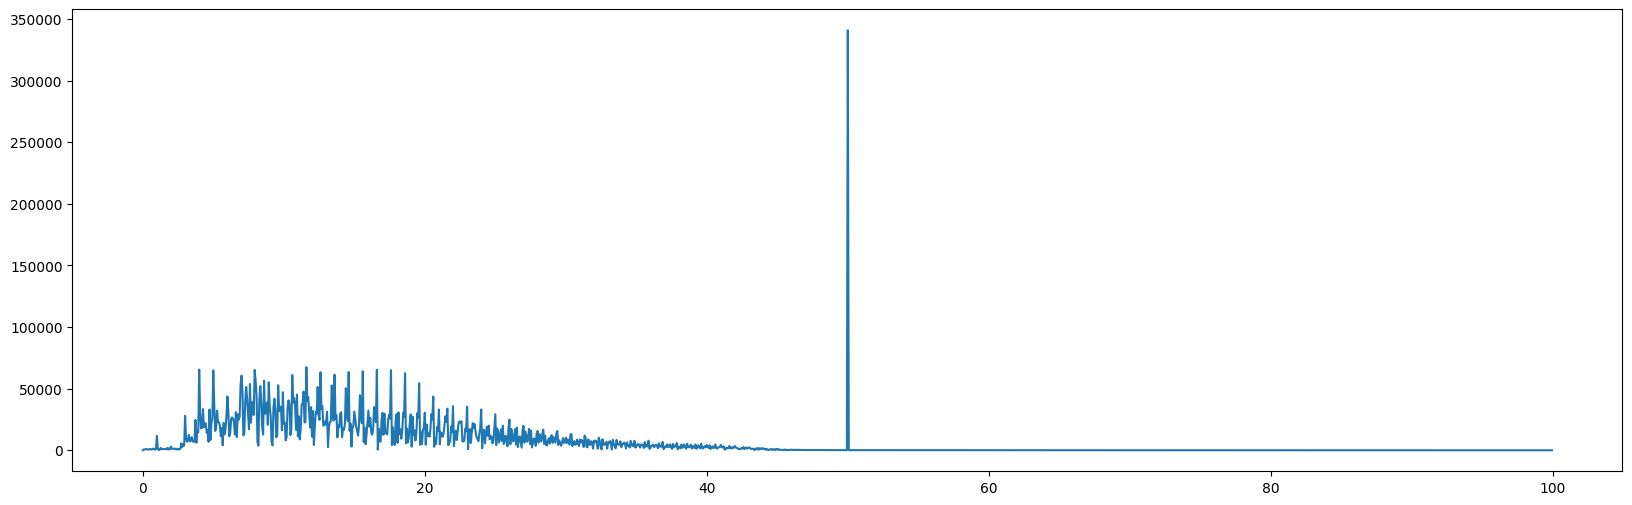

In [5]:
def SNR_calc (signal, noise):
    P_signal =0
    P_noise = 0
    spec_s = (abs(fft(signal)))
    spec_n = (abs(fft(noise)))
    for i in range(len(spec_s)):
        P_signal+=(spec_s[i])**2
        P_noise+=(spec_s[i]-spec_n[i])**2
    return 10*(math.log10(P_signal/P_noise))

f = np.arange(0, 1.0*Fs/10, 1.0*Fs/N)

spec_sn = (abs(fft(sn-np.mean(sn))))
plt.plot(f,spec_sn[0:int(N/10)])
print ("SNR: {} dB".format(SNR_calc(s, sn)))

## Filtro Pasa Bajos (FIR)

In [6]:
from ipywidgets import *

# Filtro pasa bajos
def filter_calc(fc, D, L):
    x1 = (1.0*(fc-D/2))/Fs
    x2 = (1.0*(fc+D/2))/Fs
    b = sig.remez(L, [0, x1, x2, 0.5], [1.0, 0.0],maxiter=200)
    return b

def plot_filter_resp(fc, D, L):
    b = filter_calc(fc,D,L)
    w, h = sig.freqz(b)
    w = w/(2*np.pi)*Fs
    fig = plt.figure()
    plt.title('Digital filter frequency response')
    ax1 = fig.add_subplot(111)
    plt.plot(w, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [Hz]')
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')
    plt.grid()
    plt.axis('tight')
    plt.show()

interact(plot_filter_resp, fc=(35,50,1), D=(2,20,1), L=(20, 200, 10))

interactive(children=(IntSlider(value=42, description='fc', max=50, min=35), IntSlider(value=11, description='…

<function __main__.plot_filter_resp(fc, D, L)>

interactive(children=(IntSlider(value=42, description='fc', max=50, min=35), IntSlider(value=11, description='…

SNR: 22.603981247566445 dB


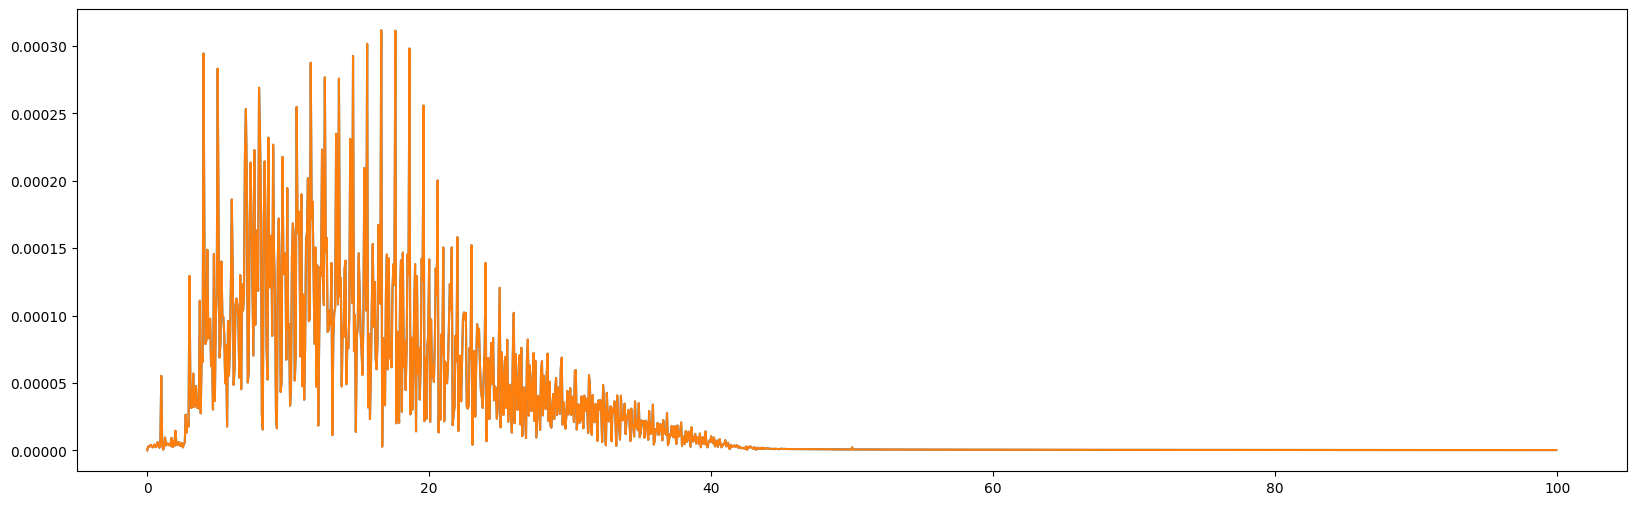

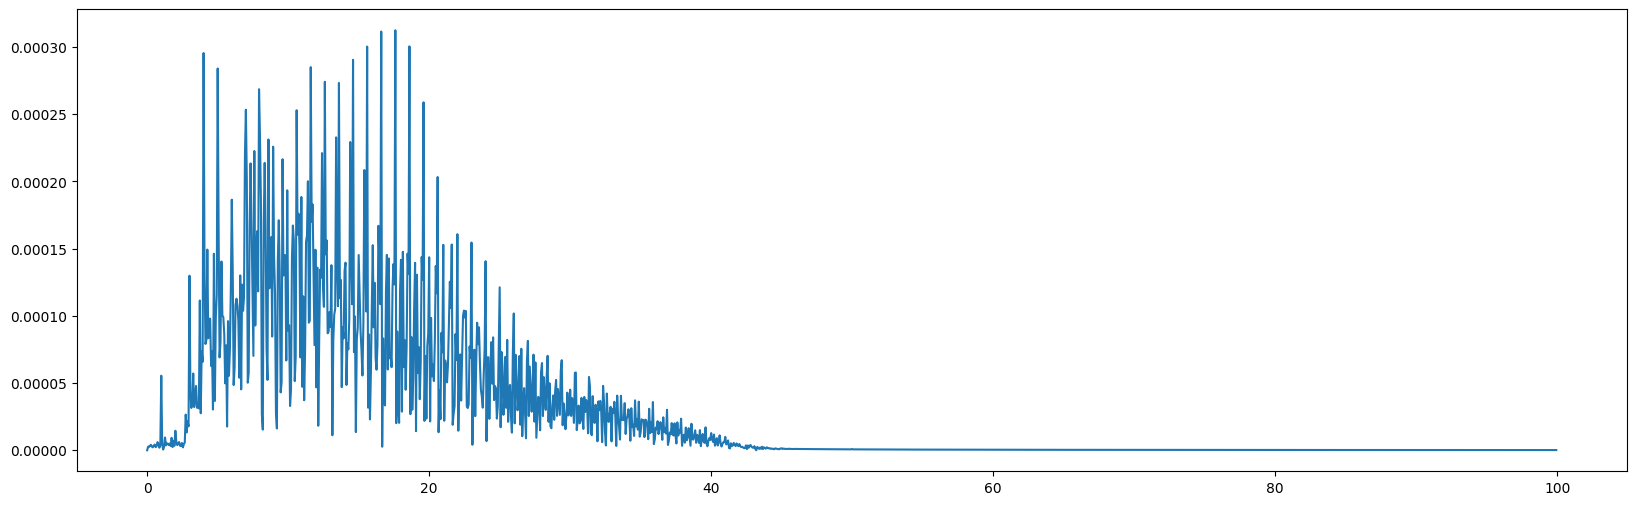

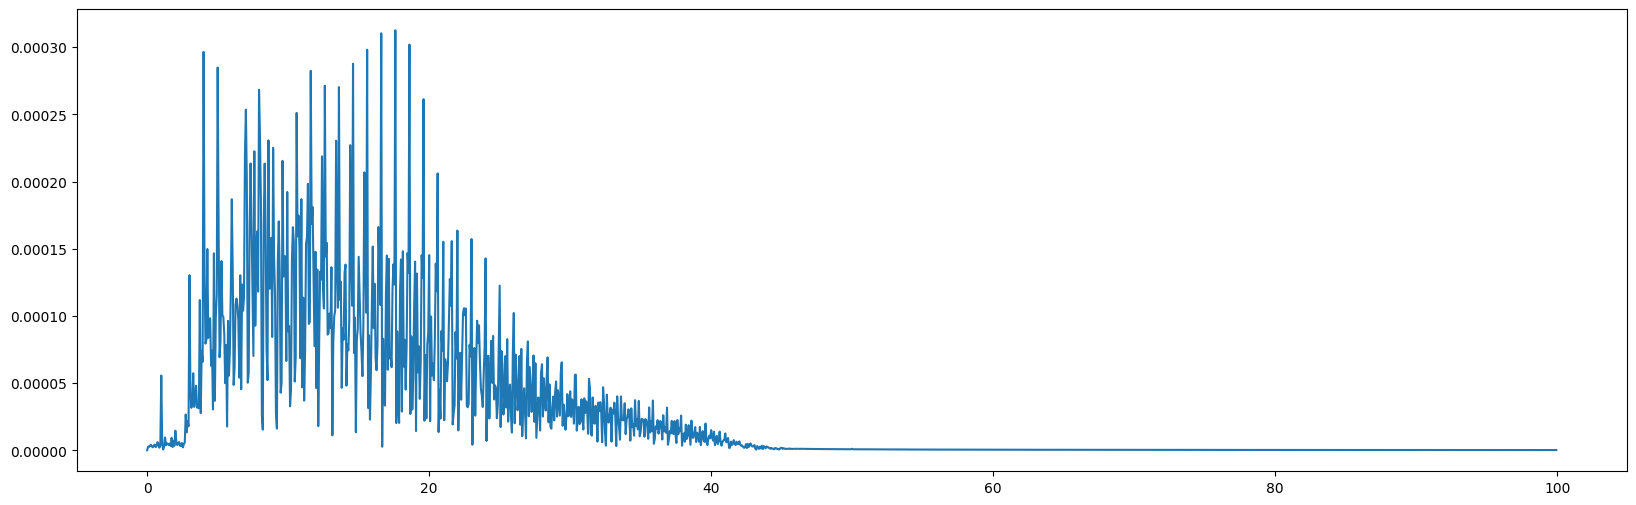

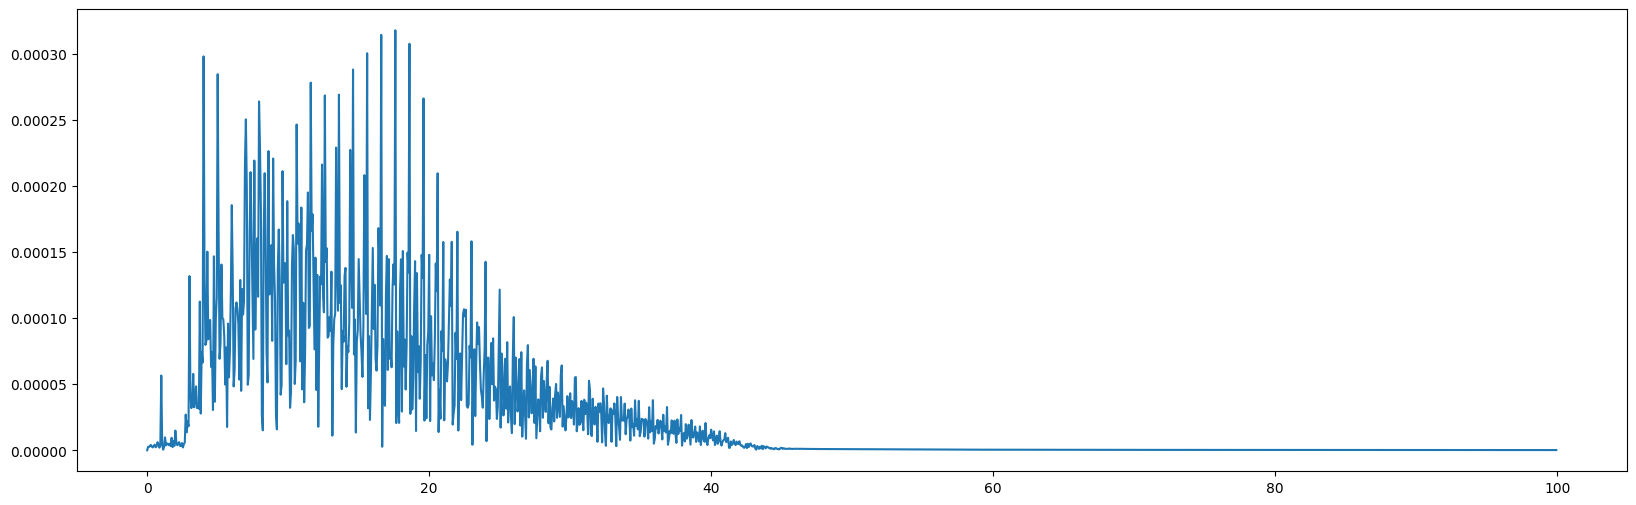

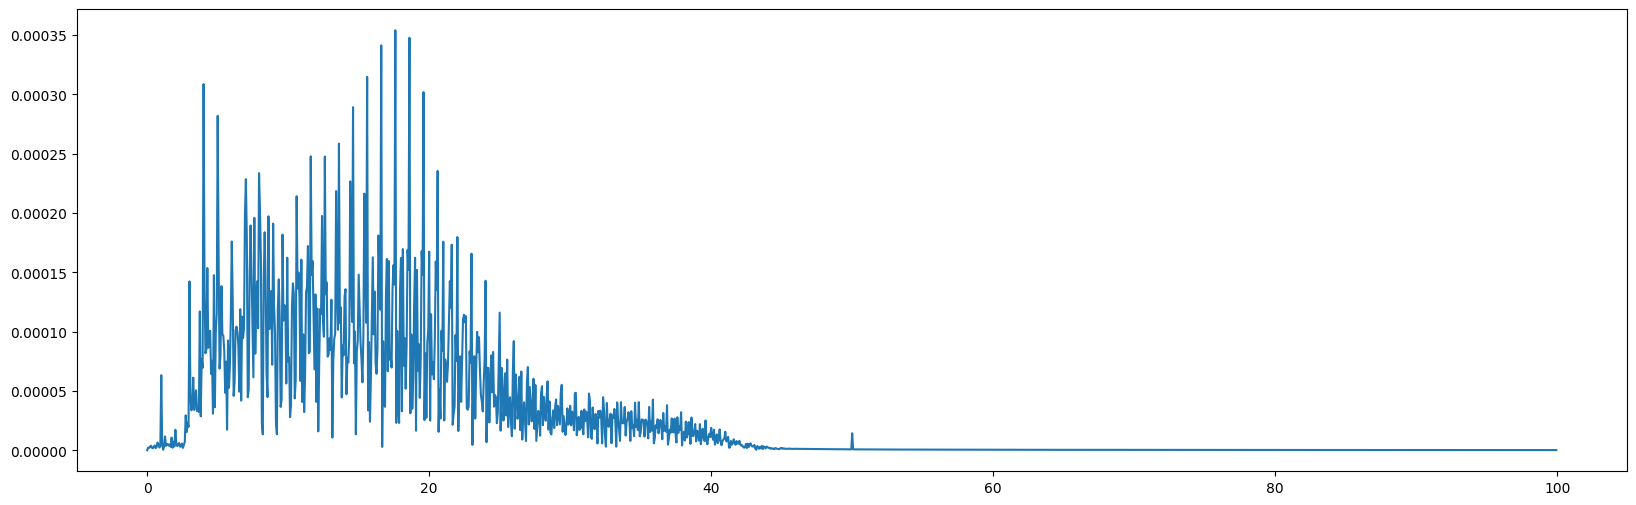

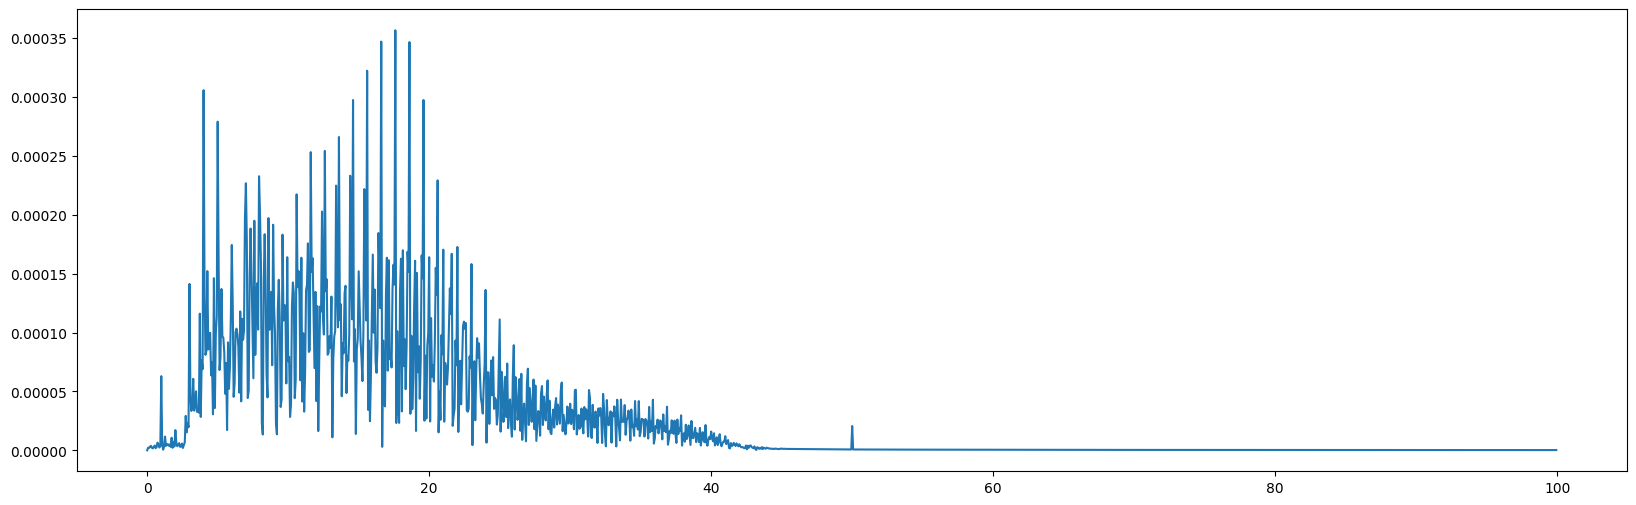

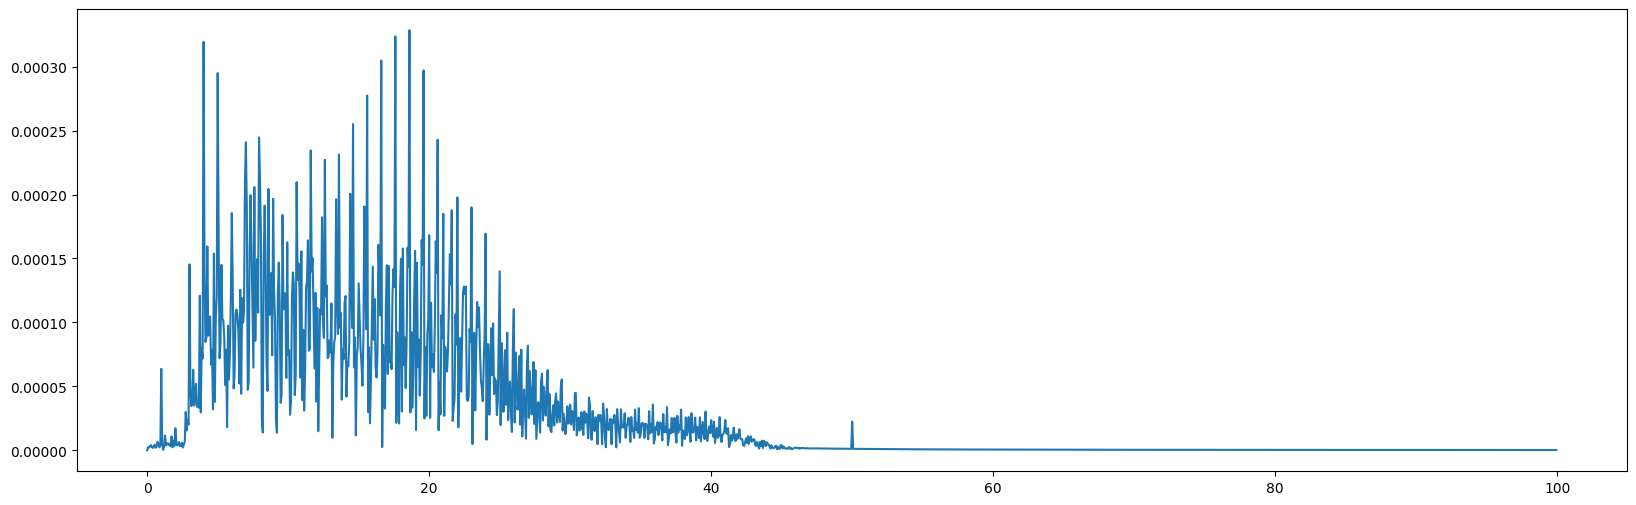

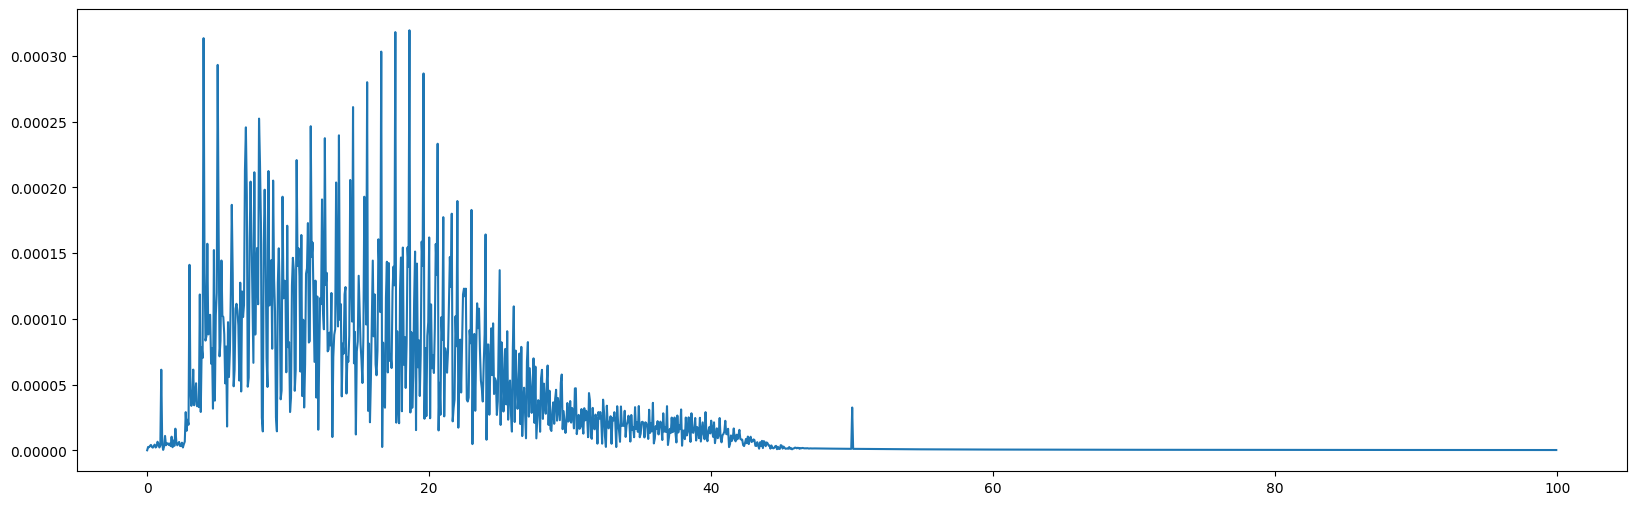

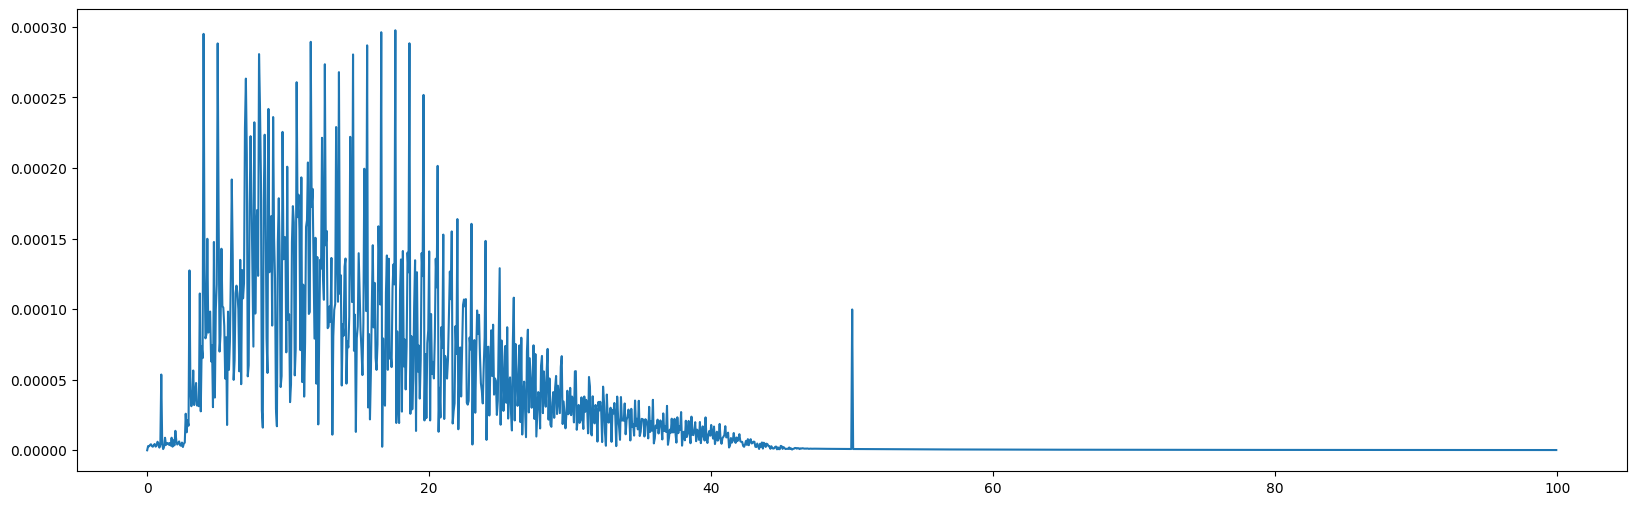

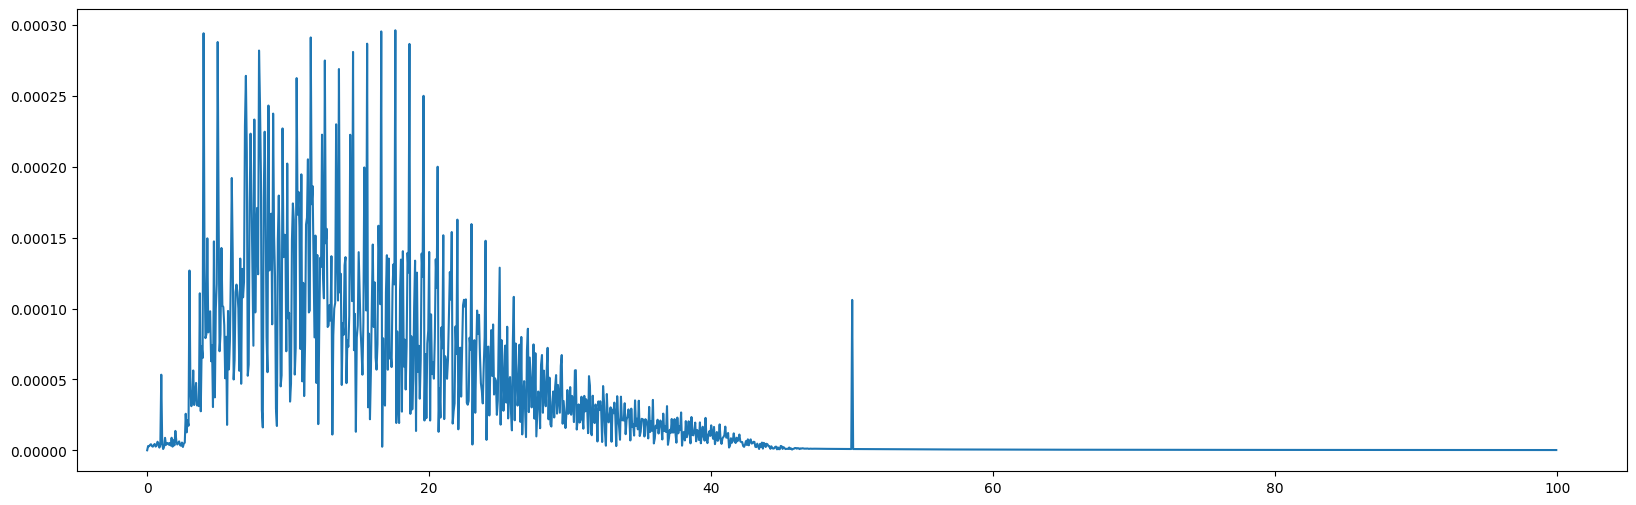

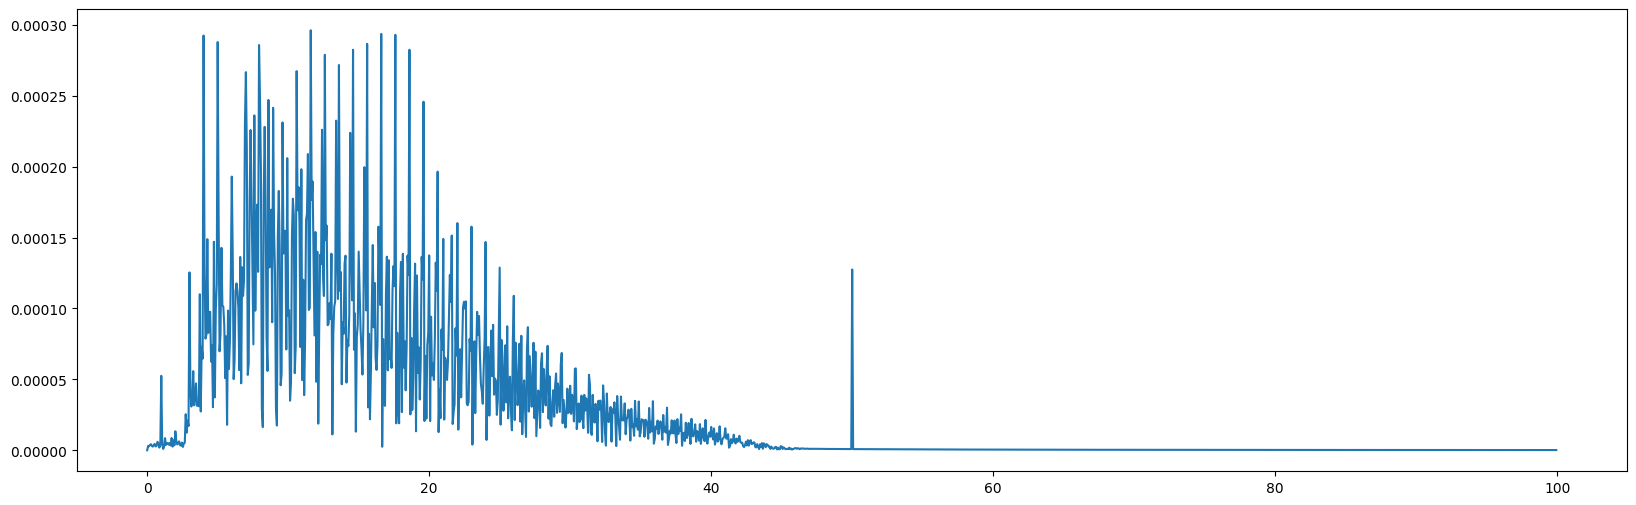

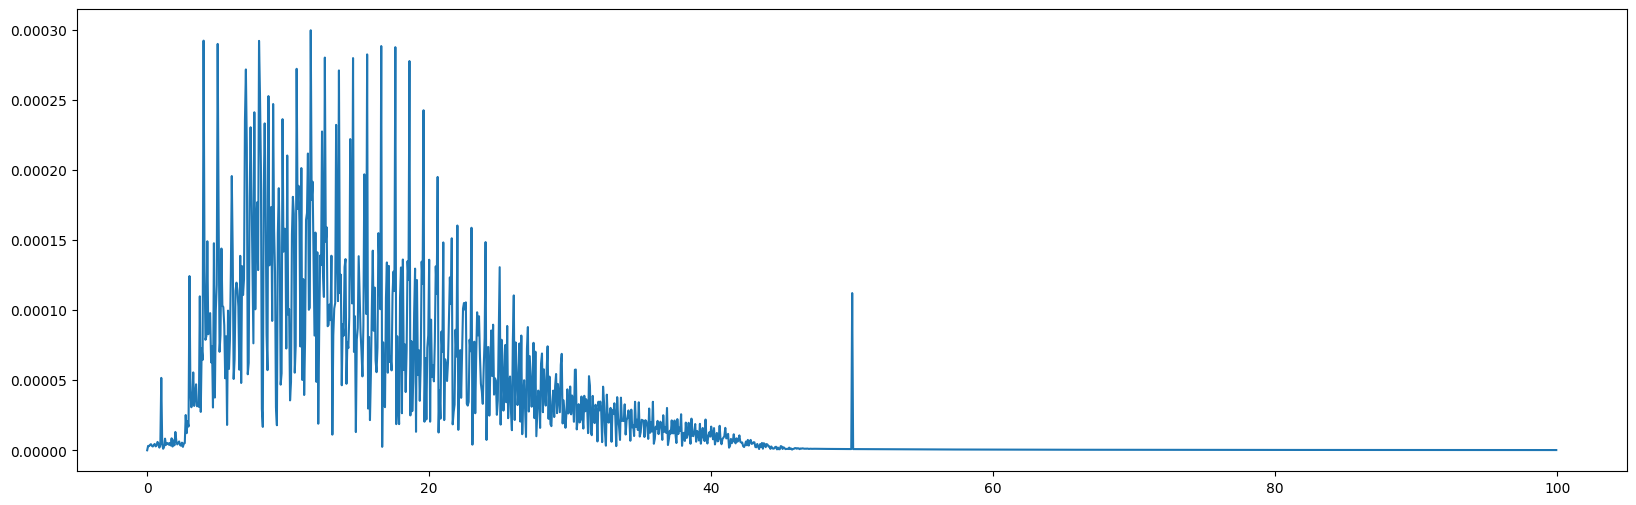

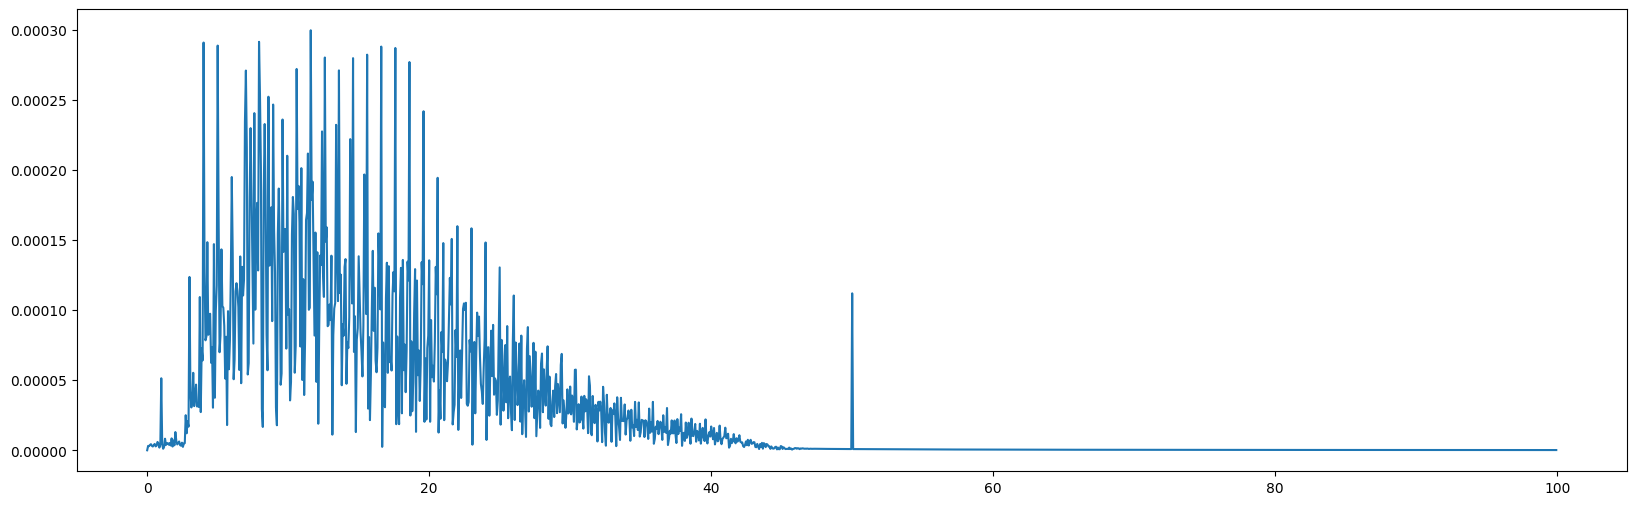

In [7]:
def spec_plot(fc, D, L):
    b = filter_calc(fc,D,L)
    s_f_lp  = sig.filtfilt(b, 1, sn)
    spec_s_f_lp = (abs(fft(s_f_lp-np.mean(s_f_lp))))/(N**2)
    plt.plot(f,spec_s_f_lp[0:int(N/10)])
    print ("SNR: {} dB".format(SNR_calc(s, s_f_lp)))
    return s_f_lp

interact(spec_plot, fc=(35,50,1), D=(2,20,1), L=(20, 200, 10))
s_f_lp= spec_plot(fc=42, D=11, L=110)

## Notch Filter

a count: 3, b count 3


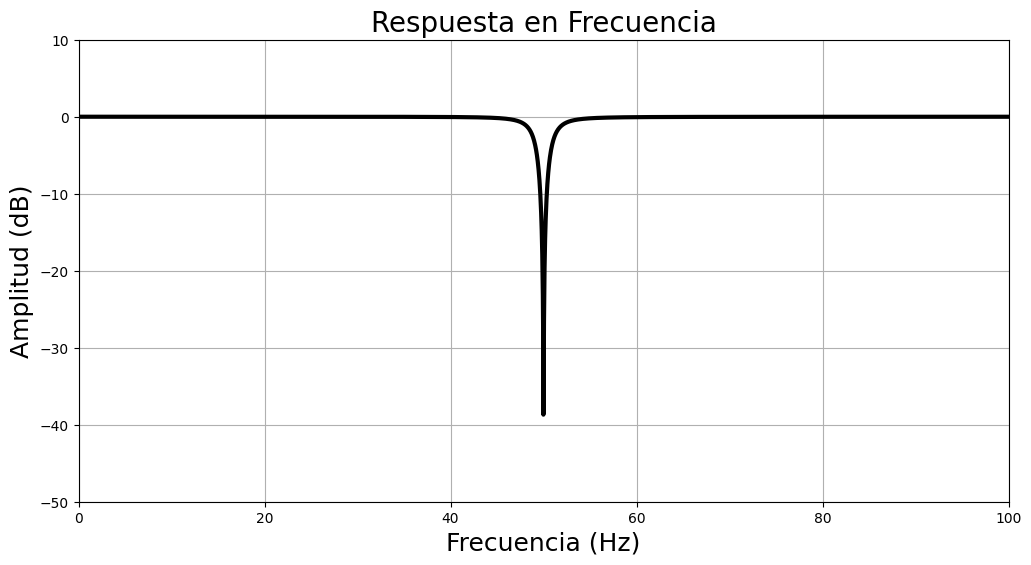

In [8]:
# Función calculo de filtro notch

def iirnotch(w0, bw, ab=3):
    """
    Diseñar un filtro digital IIR de notch de segundo orden.

    Parámetros
    ----------
    w0 : float
        Un valor escalar que debe cumplir con 0 < w0 < 1. Para
        los filtros de muesca, w0 es la frecuencia normalizada
        que se desea eliminar de la señal filtrada (w0 = 1
        corresponde a la mitad de la frecuencia de muestreo).
    bw : float
        Ancho de banda del filtro.
    ab : float, opcional
        Atenuación en decibelios. Por defecto, `ab`
        es 3. Por lo tanto, la atenuación es de -3 dB o -10*log10(1/2) dB.

    Devuelve
    --------
    b, a : ndarray, ndarray
        Polinomios del numerador (`b`) y denominador (`a`) del filtro IIR.

    Notas
    -----
    El factor de calidad (Q factor) del filtro está relacionado con el
    ancho de banda del filtro mediante Q = w0/bw (para el valor predeterminado de `ab`).

    Referencias
    ----------
    .. [1] Sophocles J. Orfanidis, "Introducción al procesamiento de señales",
          Prentice-Hall, 1996
    """


    # Normalize inputs
    bw = bw*np.pi
    w0 = w0*np.pi

    # Compute atenuation from ab
    gb = 10.0**(-ab/20.0)

    # Compute beta: formula 11.3.4 from reference [1]
    beta = (np.sqrt(1.0-gb**2.0)/gb)*np.tan(bw/2.0)

    # Compute gain: formula 11.3.6 from reference [1]
    gain = 1.0/(1.0+beta)

    # Compute numerator (`b`) and denominator (`a`):
    # formula 11.3.7 from reference [1]
    b = gain*np.array([1.0, -2.0*np.cos(w0), 1.0])
    a = np.array([1.0, -2.0*gain*np.cos(w0), (2.0*gain-1.0)])

    return (b, a)

f0 = 50.0  # Hz
q = 35.0  # Quality factor

w0 = f0/(Fs/2)
bw = w0/q

# Design notch filter
b, a = iirnotch(w0, bw, 5)

# Frequency response
w, h = sig.freqz(b, a, 2**14)
print("a count: {}, b count {}".format(len(a), len(b)))

# Generate frequency axis
freq = w*Fs/(2*np.pi)

#plot
fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.plot(freq, 20*np.log10(abs(h)), color='black', linewidth=3)
ax.grid()
ax.set_title("Respuesta en Frecuencia", fontsize=20)
ax.set_ylabel("Amplitud (dB)", fontsize=18)
ax.set_xlabel("Frecuencia (Hz)", fontsize=18)
ax.axis([0, 100, -50, 10])
plt.show()

SNR: 40.31888717392516 dB


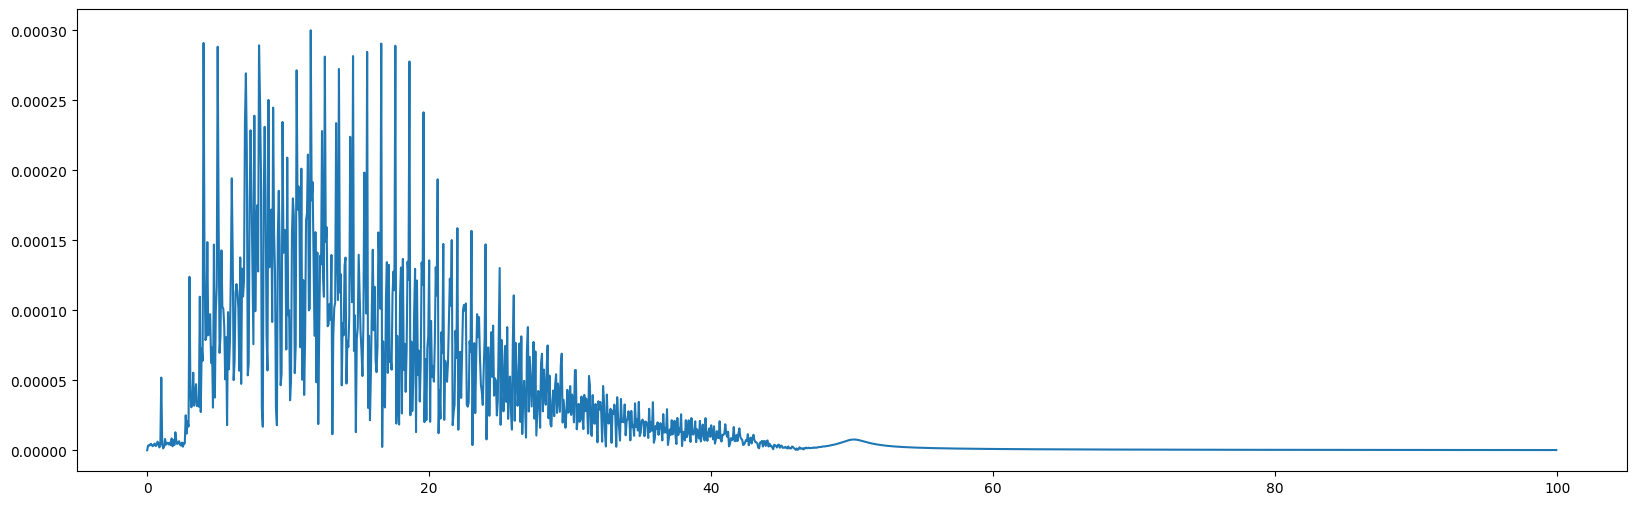

In [9]:
s_f_notch  = sig.filtfilt(b, a, sn)
spec_s_f_notch = (abs(fft(s_f_notch-np.mean(s_f_notch))))/(N**2)
plt.plot(f,spec_s_f_notch[0:int(N/10)])
print ("SNR: {} dB".format(SNR_calc(s, s_f_notch)))

## FFT Filter

SNR: 115.34094977469353 dB


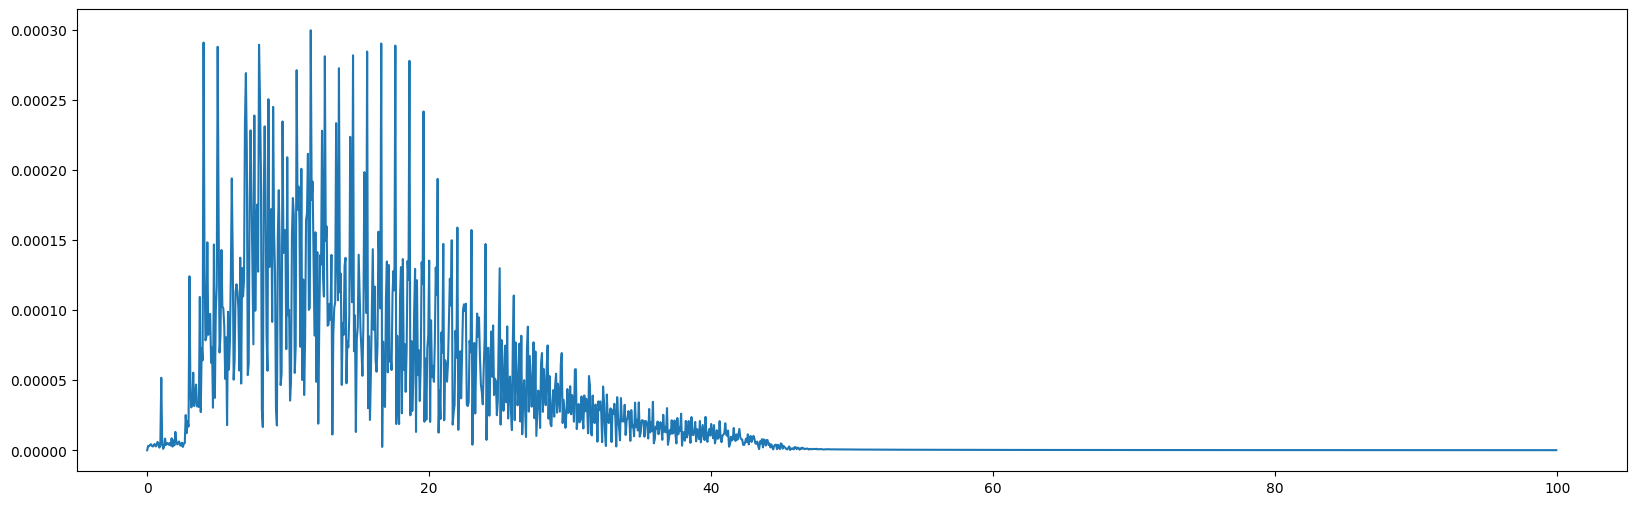

In [10]:
# FFT filter
rf_sn = rfft(sn)
i=int(50.0/((1.0*Fs/2)/N))
rf_sn[i] = 0
s_f_fft = irfft(rf_sn)
spec_s_f_fft = (abs(fft(s_f_fft-np.mean(s_f_fft))))/(N**2)
plt.plot(f,spec_s_f_fft[0:int(N/10)])
print ("SNR: {} dB".format(SNR_calc(s, s_f_fft)))

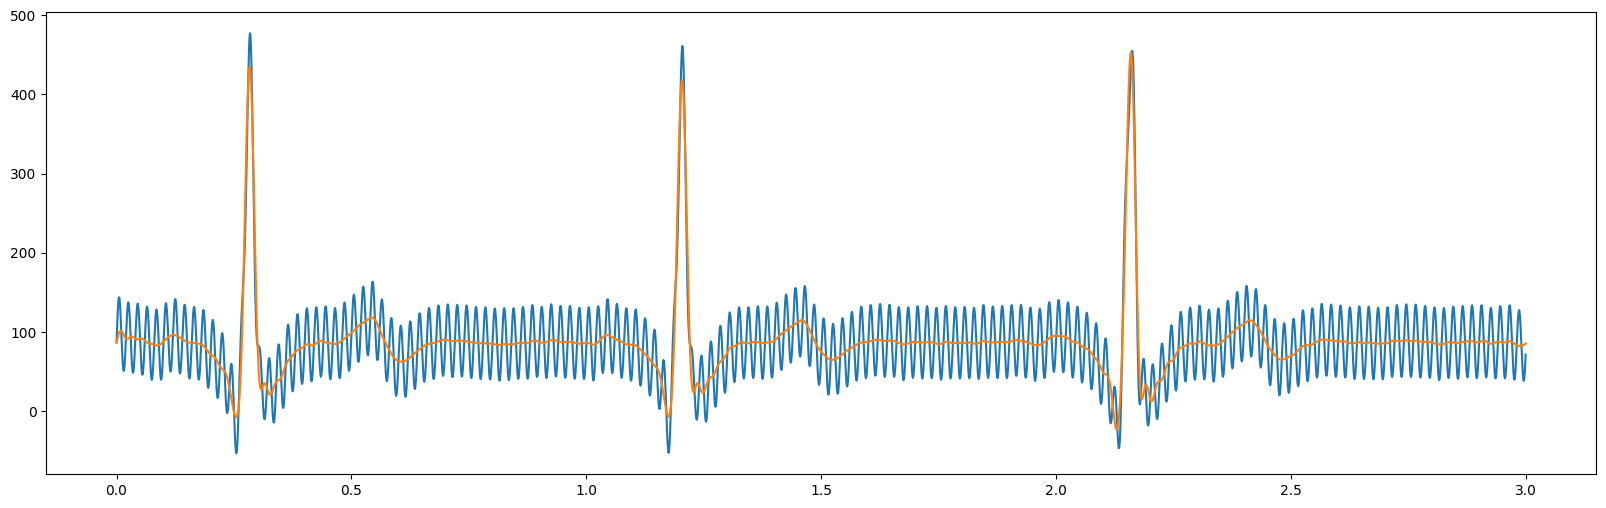

In [11]:
#señal con ruido y sin ruido
plt.plot(t[0:3*Fs], sn [0:Fs*3])
plt.plot(t[0:3*Fs], s[0:Fs*3])

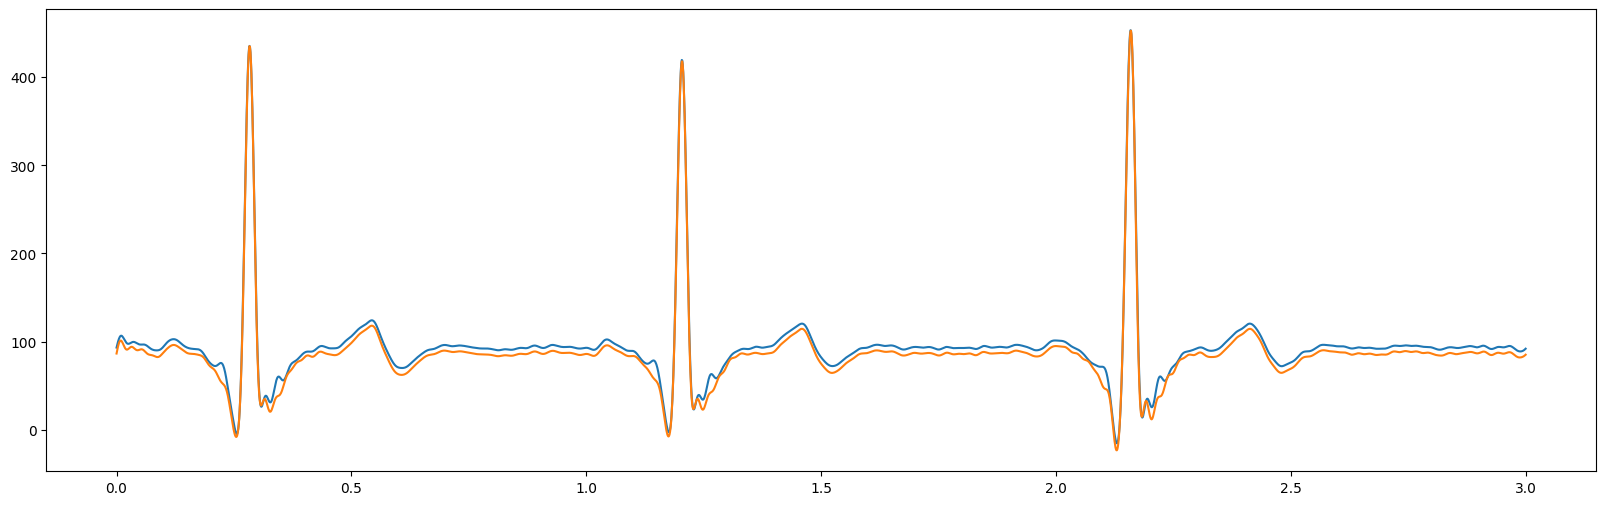

In [12]:
#Filtro pasa bajo
plt.plot(t[0:3*Fs], s_f_lp [0:Fs*3])
plt.plot(t[0:3*Fs], s[0:Fs*3])

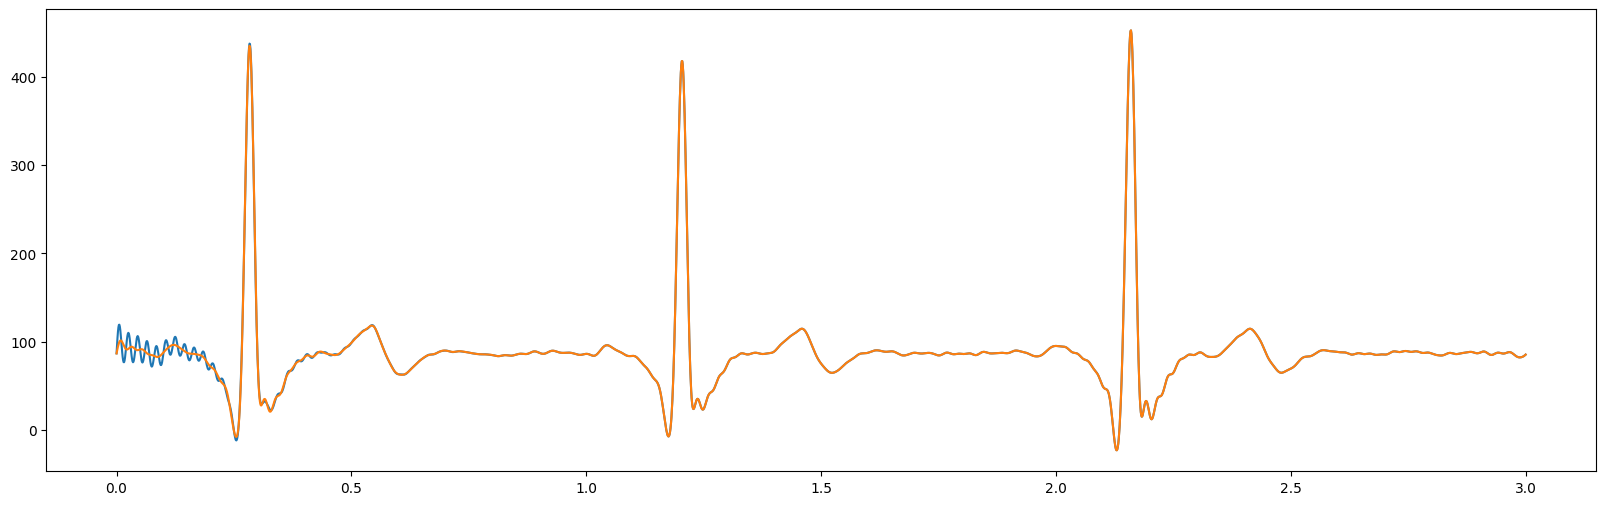

In [13]:
# Filtro Notch
plt.plot(t[0:3*Fs], s_f_notch [0:Fs*3])
plt.plot(t[0:3*Fs], s[0:Fs*3])

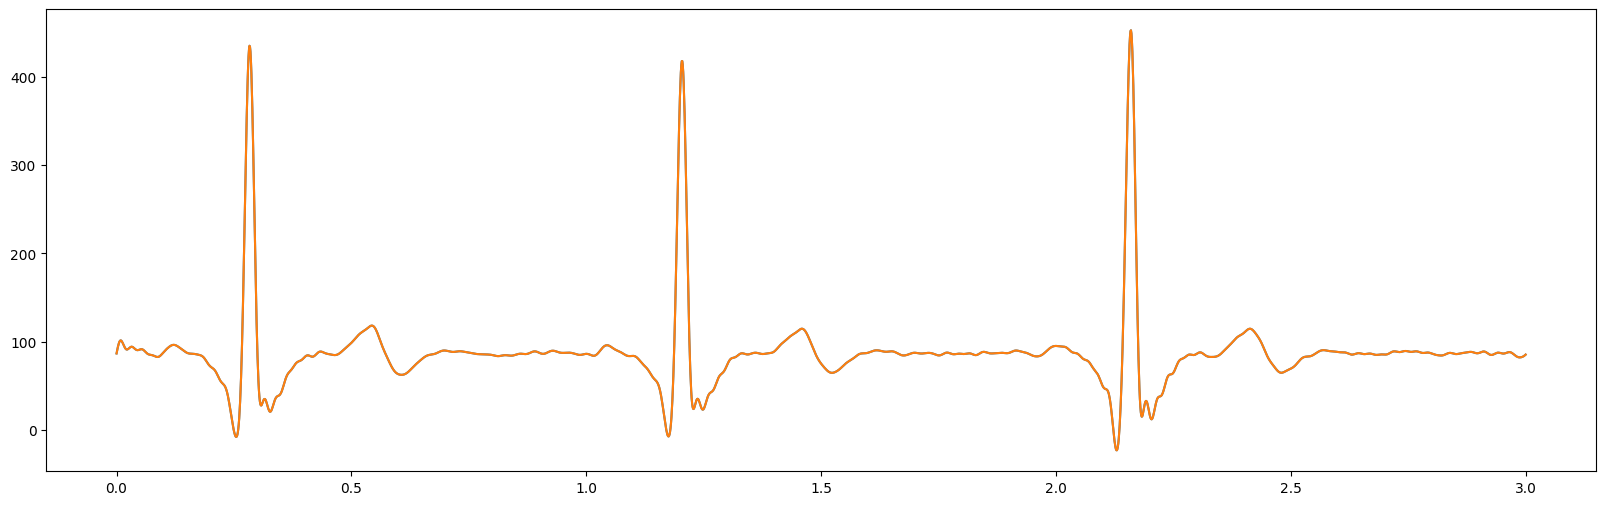

In [14]:
# Filtro FFT
plt.plot(t[0:3*Fs], s_f_fft [0:Fs*3])
plt.plot(t[0:3*Fs], s[0:Fs*3])